## **1. 환경변수 결측치 채우기**

#### MICE로 결측값 채우기 (~ 내부 이산화탄소 농도)

In [2]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df= pd.read_excel('개체번호, 연도 통합.xlsx', sheet_name='combined')

In [4]:
df.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MSRM_DT          17544 non-null  datetime64[ns]
 1   AREA_TPRT        17539 non-null  float64       
 2   AREA_HMDT        17517 non-null  float64       
 3   AREA_WDSP        17544 non-null  float64       
 4   INNER_TPRT       10100 non-null  float64       
 5   INNER_HMDT       9615 non-null   float64       
 6   INNER_CBDX_CTRN  7528 non-null   float64       
 7   EXTN_TPRT        0 non-null      float64       
 8   PLT_LNGTH        120 non-null    float64       
 9   LEAF_LNGTH       1488 non-null   float64       
 10  LEAF_WDTH        1488 non-null   float64       
 11  STEM_THNS        1488 non-null   float64       
 12  SHPMN_QTY        2640 non-null   float64       
 13  SHPMN_AMT        2640 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memo

In [7]:
# 날짜 컬럼을 datetime 형식으로 변환
df['MSRM_DT'] = pd.to_datetime(df['MSRM_DT'])


In [8]:
# 각 컬럼의 결측치 비율 확인
missing_values = df.isnull().sum() / len(df) * 100
print("결측치 비율:\n", missing_values)


결측치 비율:
 MSRM_DT              0.000000
AREA_TPRT            0.028500
AREA_HMDT            0.153899
AREA_WDSP            0.000000
INNER_TPRT          42.430461
INNER_HMDT          45.194938
INNER_CBDX_CTRN     57.090743
EXTN_TPRT          100.000000
PLT_LNGTH           99.316005
LEAF_LNGTH          91.518468
LEAF_WDTH           91.518468
STEM_THNS           91.518468
SHPMN_QTY           84.952120
SHPMN_AMT           84.952120
dtype: float64


In [9]:
#MICE 이용하여 지역, 내부환경 결측값 채우기

In [10]:
df2 = df.copy(deep=True)

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MSRM_DT          17544 non-null  datetime64[ns]
 1   AREA_TPRT        17539 non-null  float64       
 2   AREA_HMDT        17517 non-null  float64       
 3   AREA_WDSP        17544 non-null  float64       
 4   INNER_TPRT       10100 non-null  float64       
 5   INNER_HMDT       9615 non-null   float64       
 6   INNER_CBDX_CTRN  7528 non-null   float64       
 7   EXTN_TPRT        0 non-null      float64       
 8   PLT_LNGTH        120 non-null    float64       
 9   LEAF_LNGTH       1488 non-null   float64       
 10  LEAF_WDTH        1488 non-null   float64       
 11  STEM_THNS        1488 non-null   float64       
 12  SHPMN_QTY        2640 non-null   float64       
 13  SHPMN_AMT        2640 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memo

In [12]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# 결측값을 MICE 모델로 채우는 함수
def fill_missing_with_mice(df, max_iter=100, random_state=0):
    # IterativeImputer 초기화
    imputer = IterativeImputer(max_iter=max_iter, random_state=random_state)

    # 전체 데이터프레임에서 결측값 대체
    imputed_data = imputer.fit_transform(df)

    # 원래의 데이터프레임과 동일한 구조로 데이터프레임 생성
    imputed_df = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

    return imputed_df

# 임의로 결측값 추가하는 함수
def introduce_missing_values_randomly(df, missing_fraction=0.2, random_state=0):
    np.random.seed(random_state)
    df_with_missing = df.copy()

    # 총 셀 수에서 결측값을 추가할 개수 계산
    total_cells = df.size
    num_missing = int(total_cells * missing_fraction)

    # 랜덤하게 결측치를 추가할 위치 선택
    for _ in range(num_missing):
        row = random.randint(0, df.shape[0] - 1)
        col = random.randint(0, df.shape[1] - 1)
        df_with_missing.iat[row, col] = np.nan

    return df_with_missing

# 환경 변수 리스트 (사용자가 제공한 변수)
env_vars = ['AREA_TPRT', 'AREA_HMDT', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN']

# 결측치가 없는 행만 필터링
df_no_missing = df2[env_vars].dropna()

# 결측치 없는 데이터에서 일부 값을 임의로 결측치로 변환
df_with_random_missing = introduce_missing_values_randomly(df_no_missing, missing_fraction=0.3)

# MICE로 결측치를 채움
df_imputed = fill_missing_with_mice(df_with_random_missing)
# 결측치 없는 데이터의 인덱스를 원본 데이터에서 추출
selected_indices = df_no_missing.index

# 원본 데이터 df2에서 필터링된 인덱스만 뽑아 새로운 df3 생성
df3 = df2.loc[selected_indices]

def evaluate_performance(original_series, imputed_series):

    original_values = original_series
    imputed_values = imputed_series

    mse = mean_squared_error(original_values, imputed_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original_values, imputed_values)

    # 평가 결과 출력
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

# 각 변수에 대해 성능 평가
for var in env_vars:
    print(f"Evaluating performance for {var}...")

    # 성능 평가 (임의로 결측치로 만든 값들에 대해 원래 값과 대체된 값 비교)
    evaluate_performance(df3[var], df_imputed[var])


Evaluating performance for AREA_TPRT...
MSE: 10.913549659756843
RMSE: 3.3035662033258606
MAE: 1.2854044707325005
Evaluating performance for AREA_HMDT...
MSE: 119.89407671179328
RMSE: 10.949615368212404
MAE: 4.48876501841477
Evaluating performance for INNER_TPRT...
MSE: 6.3825551403885346
RMSE: 2.5263719323149028
MAE: 0.9810866131159129
Evaluating performance for INNER_HMDT...
MSE: 55.33116006402124
RMSE: 7.438491786916299
MAE: 2.9653706199698213
Evaluating performance for INNER_CBDX_CTRN...
MSE: 13494.000317213084
RMSE: 116.16367899310474
MAE: 46.4000285855504


In [13]:
df_imputed

,AREA_TPRT,AREA_HMDT,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN
180,3.400000,54.297879,22.100000,72.0,758.237253
181,27.098216,33.000000,34.300000,87.0,601.000000
182,28.837160,28.000000,40.600000,61.0,985.000000
183,4.400000,24.000000,35.700000,54.0,868.000000
184,14.459302,29.000000,26.640059,58.0,637.933165
...,...,...,...,...,...
14241,28.100000,96.310336,24.800000,95.3,691.267893
14242,30.000000,78.000000,25.000000,96.7,626.992826
14243,30.700000,102.440996,26.100000,93.8,944.000000
14244,32.100000,64.000000,28.200000,89.5,541.026167


In [14]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7295 entries, 180 to 14255
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AREA_TPRT        7295 non-null   float64
 1   AREA_HMDT        7295 non-null   float64
 2   INNER_TPRT       7295 non-null   float64
 3   INNER_HMDT       7295 non-null   float64
 4   INNER_CBDX_CTRN  7295 non-null   float64
dtypes: float64(5)
memory usage: 342.0 KB


In [15]:
df4 = df.copy(deep=True)

In [16]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # Required to enable the IterativeImputer
from sklearn.impute import IterativeImputer

# Defining the environmental variables
env_vars = ['AREA_TPRT', 'AREA_HMDT', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN']

# Applying MICE using IterativeImputer only to the selected columns
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit the imputer on env_vars and transform the data
imputed_values = imputer.fit_transform(df2[env_vars])

# Update the original DataFrame with the imputed values for the specified columns
df4[env_vars] = imputed_values

# Results
print("Data After Imputing Missing Values for Selected Columns with MICE:")
print(df4.head())

Data After Imputing Missing Values for Selected Columns with MICE:
              MSRM_DT  AREA_TPRT  AREA_HMDT  AREA_WDSP  INNER_TPRT  \
0 2019-01-01 00:00:00       -1.9       50.0        1.6        19.1   
1 2019-01-01 01:00:00       -3.2       54.0        1.7        18.8   
2 2019-01-01 02:00:00       -2.5       62.0        2.1        18.5   
3 2019-01-01 03:00:00       -2.5       62.0        1.6        18.1   
4 2019-01-01 04:00:00       -3.6       67.0        0.8        17.8   

   INNER_HMDT  INNER_CBDX_CTRN  EXTN_TPRT  PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  \
0        87.0       840.911874        NaN        NaN         NaN        NaN   
1        87.0       856.601990        NaN        NaN         NaN        NaN   
2        87.0       871.298626        NaN        NaN         NaN        NaN   
3        87.0       878.309889        NaN        NaN         NaN        NaN   
4        88.0       893.520363        NaN        NaN         NaN        NaN   

   STEM_THNS  SHPMN_QTY  SHPMN_AMT  


In [17]:
# 각 컬럼의 결측치 비율 확인
missing_values = df4.isnull().sum() / len(df) * 100
print("결측치 비율:\n", missing_values)

결측치 비율:
 MSRM_DT              0.000000
AREA_TPRT            0.000000
AREA_HMDT            0.000000
AREA_WDSP            0.000000
INNER_TPRT           0.000000
INNER_HMDT           0.000000
INNER_CBDX_CTRN      0.000000
EXTN_TPRT          100.000000
PLT_LNGTH           99.316005
LEAF_LNGTH          91.518468
LEAF_WDTH           91.518468
STEM_THNS           91.518468
SHPMN_QTY           84.952120
SHPMN_AMT           84.952120
dtype: float64


## **2. 외부 온도 채우기**

#### 외부 생산량 데이터에서 외부 온도 결측값 채우는 모델 적합하기

In [18]:
pip install pykalman

Note: you may need to restart the kernel to use updated packages.


In [19]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd

In [20]:
df = pd.read_excel('외부생산량.xlsx')
df.head()

,FARM_ID,MSRM_DT,AREA_NM,AREA_TPRT,AREA_HMDT,AREA_WDSP,EXTN_TPRT,EXTN_WDSP,EXTN_SRQT,SHPMN_QTY
0,GBE_KRMLN_002000aa,2019-01-01 00:00:00,성주,-1.9,50,1.6,NaN,NaN,NaN,NaN
1,GBE_KRMLN_002000aa,2019-01-01 01:00:00,성주,-3.2,54,1.7,NaN,NaN,NaN,NaN
2,GBE_KRMLN_002000aa,2019-01-01 02:00:00,성주,-2.5,62,2.1,NaN,NaN,NaN,NaN
3,GBE_KRMLN_002000aa,2019-01-01 03:00:00,성주,-2.5,62,1.6,NaN,NaN,NaN,NaN
4,GBE_KRMLN_002000aa,2019-01-01 04:00:00,성주,-3.6,67,0.8,NaN,NaN,NaN,NaN


In [21]:
df1 = df[['AREA_TPRT','AREA_HMDT','AREA_WDSP','EXTN_TPRT']]
df1 = df1.dropna(axis=0)
df1

,AREA_TPRT,AREA_HMDT,AREA_WDSP,EXTN_TPRT
180,3.4,36,2.4,11.9
181,4.1,33,2.6,7.5
182,4.2,28,2.5,7.6
183,4.4,24,2.8,8.0
184,3.5,29,2.6,6.2
...,...,...,...,...
4795,25.8,98,1.0,14.0
4796,25.2,99,0.4,13.2
4797,25.2,99,0.3,11.8
4798,24.6,99,0.6,10.5


In [22]:
np.corrcoef(df1['AREA_TPRT'],df1['EXTN_TPRT'])

array([[1.        , 0.69461408],
       [0.69461408, 1.        ]])

In [23]:
np.corrcoef(df1['AREA_HMDT'],df1['EXTN_TPRT'])

array([[ 1.        , -0.19999802],
       [-0.19999802,  1.        ]])

In [24]:
np.corrcoef(df1['AREA_WDSP'],df1['EXTN_TPRT'])

array([[1.        , 0.19000894],
       [0.19000894, 1.        ]])

In [25]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error

# NaN이 아닌 셀들 중에서 일부러 결측값을 생성하는 함수
def create_random_missing_cells(data, column_name, missing_fraction):
    data_copy = data.copy()

    # NaN 값이 아닌 셀들의 인덱스를 찾음 (특정 열에 대해)
    non_missing_indices = [i for i in range(data_copy.shape[0]) if not np.isnan(data_copy[column_name].iloc[i])]

    # 결측값으로 만들 셀 개수
    n_total_non_missing = len(non_missing_indices)
    n_missing_cells = int(np.floor(missing_fraction * n_total_non_missing))

    # 무작위로 NaN이 아닌 셀을 선택
    missing_indices = np.random.choice(non_missing_indices, n_missing_cells, replace=False)

    # 선택된 셀을 NaN으로 변환 (특정 열에 대해)
    data_copy.loc[missing_indices, column_name] = np.nan

    return data_copy, missing_indices

In [26]:
df = pd.read_excel('외부생산량.xlsx')

In [27]:
df.isnull().sum()

FARM_ID         0
MSRM_DT         0
AREA_NM         0
AREA_TPRT       0
AREA_HMDT       0
AREA_WDSP       0
EXTN_TPRT    6444
EXTN_WDSP    8760
EXTN_SRQT    8760
SHPMN_QTY    7368
dtype: int64

In [28]:
# 독립변수: 지역온도, 지역습도, 지역풍속
X = df[['AREA_TPRT']].values

# 종속변수: 외부온도 (결측값 포함)
external_temp = df['EXTN_TPRT'].values

# 종속변수: 외부온도 (EXTN_TPRT)에서 일부러 결측값을 생성
missing_data, missing_indices = create_random_missing_cells(df.copy(), 'EXTN_TPRT', missing_fraction=0.1)

missing_data.isnull().sum()

FARM_ID         0
MSRM_DT         0
AREA_NM         0
AREA_TPRT       0
AREA_HMDT       0
AREA_WDSP       0
EXTN_TPRT    6675
EXTN_WDSP    8760
EXTN_SRQT    8760
SHPMN_QTY    7368
dtype: int64

In [29]:
# Kalman 필터 설정
kf = KalmanFilter(
    transition_matrices=np.eye(1),  # 상태 전이 행렬 (1x1 단위 행렬)
    observation_matrices=np.ones((1, 1)),  # 관측 행렬 (3개의 독립변수 사용)
    initial_state_mean=np.zeros(1),  # 초기 상태 평균 (1차원 상태)
    observation_covariance=np.eye(1),  # 관측 오차 행렬
    transition_covariance=np.eye(1),  # 상태 전이 오차 행렬
    n_dim_state=1,  # 상태 차원 (외부온도, 1차원)
    n_dim_obs=1  # 관측 차원 (지역온도, 지역습도, 지역풍속)
)

In [30]:
# 결측값이 있는 열에 대해 Kalman 필터 적용
kf = kf.em(X, n_iter=10)
# 필터링을 통해 외부온도의 결측값 보정
external_temp_filled, _ = kf.smooth(X)

# 성능 평가 (원래 값과 적합된 값 비교)
# 원래 결측값이 아닌, 일부러 NaN으로 만든 셀들의 값을 비교
original_values = df['EXTN_TPRT'].values  # 원래의 외부온도 값
filled_values = external_temp_filled.flatten()  # Kalman 필터로 채운 값

# 성능 평가 (원래 결측값과 적합된 값의 RMSE 계산)
missing_original_values = [original_values[i] for i in missing_indices]  # 원래 결측값이 아닌 셀의 값
missing_filled_values = [filled_values[i] for i in missing_indices]  # Kalman 필터로 채운 값

# RMSE 계산
rmse = np.sqrt(mean_squared_error(missing_original_values, missing_filled_values))
print(f'RMSE: {rmse}')

RMSE: 10.435669326146654


#### 외부온도 모델 적합 후 개체연도 통합 파일의 지역온도를 통해 개체연도 통합 파일의 외부온도 결측값 채우기

다른 변수들은 사용하지 않고 지역온도만 사용해서 외부온도 결측치 채움

In [31]:
df4.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,840.911874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,856.601990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,871.298626,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,878.309889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,893.520363,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.head()

,FARM_ID,MSRM_DT,AREA_NM,AREA_TPRT,AREA_HMDT,AREA_WDSP,EXTN_TPRT,EXTN_WDSP,EXTN_SRQT,SHPMN_QTY
0,GBE_KRMLN_002000aa,2019-01-01 00:00:00,성주,-1.9,50,1.6,NaN,NaN,NaN,NaN
1,GBE_KRMLN_002000aa,2019-01-01 01:00:00,성주,-3.2,54,1.7,NaN,NaN,NaN,NaN
2,GBE_KRMLN_002000aa,2019-01-01 02:00:00,성주,-2.5,62,2.1,NaN,NaN,NaN,NaN
3,GBE_KRMLN_002000aa,2019-01-01 03:00:00,성주,-2.5,62,1.6,NaN,NaN,NaN,NaN
4,GBE_KRMLN_002000aa,2019-01-01 04:00:00,성주,-3.6,67,0.8,NaN,NaN,NaN,NaN


In [33]:
# 독립변수: 지역온도, 지역습도, 지역풍속
X = df[['AREA_TPRT']].values

# 종속변수: 외부온도 (결측값 포함)
external_temp = df['EXTN_TPRT'].values

# Kalman 필터 설정
kf = KalmanFilter(
    transition_matrices=np.eye(1),  # 상태 전이 행렬 (1x1 단위 행렬)
    observation_matrices=np.ones((1, 1)),  # 관측 행렬 (3x1으로 독립변수 3개가 상태 변수에 미치는 영향)
    initial_state_mean=np.zeros(1),  # 초기 상태 평균 (1차원 상태)
    observation_covariance=np.eye(1),  # 관측 오차 행렬 (3x3으로 독립변수 잡음 반영)
    transition_covariance=np.eye(1),  # 상태 전이 오차 행렬 (1x1)
    n_dim_state=1,  # 상태 차원 (외부온도, 1차원)
    n_dim_obs=1  # 관측 차원 (독립변수 3개)
)

# 칼만 필터로 외부온도의 결측값을 채움 (X를 기반으로 학습)
kf = kf.em(X, n_iter=10)

# df_com에서 지역온도를 기반으로 외부온도 예측하기
X_com = df4[['AREA_TPRT']].values  # df_com의 지역온도 값

# Kalman 필터로 df_com의 외부온도 예측
external_temp_com_filled, _ = kf.smooth(X_com)  # df_com에서 외부온도를 예측

# 예측된 외부온도를 df_com의 EXTN_TPRT 열에 채워 넣기
df4['EXTN_TPRT'] = external_temp_com_filled.flatten()

# 예측된 외부온도 확인
df4.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,840.911874,-2.000705,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,856.601990,-3.072417,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,871.298626,-2.544091,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,878.309889,-2.568719,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,893.520363,-3.455161,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df4.shape

(17544, 14)

## **3. 생육 데이터 채우기**

In [35]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   MSRM_DT          17544 non-null  datetime64[ns]
 1   AREA_TPRT        17544 non-null  float64       
 2   AREA_HMDT        17544 non-null  float64       
 3   AREA_WDSP        17544 non-null  float64       
 4   INNER_TPRT       17544 non-null  float64       
 5   INNER_HMDT       17544 non-null  float64       
 6   INNER_CBDX_CTRN  17544 non-null  float64       
 7   EXTN_TPRT        17544 non-null  float64       
 8   PLT_LNGTH        120 non-null    float64       
 9   LEAF_LNGTH       1488 non-null   float64       
 10  LEAF_WDTH        1488 non-null   float64       
 11  STEM_THNS        1488 non-null   float64       
 12  SHPMN_QTY        2640 non-null   float64       
 13  SHPMN_AMT        2640 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memo

In [36]:
# 필요한 열들만 선택 (PLT_LNGTH, LEAF_LNGTH, LEAF_WDTH, STEM_THNS)
df_filtered = df4[['PLT_LNGTH', 'LEAF_LNGTH', 'LEAF_WDTH', 'STEM_THNS']]

# 결측값이 있는 행 제거
df_clean = df_filtered.dropna()

# 상관관계 계산
correlation_matrix = df_clean.corr()

# 상관관계 출력
print(correlation_matrix)

            PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  STEM_THNS
PLT_LNGTH    1.000000    0.980627   0.903477   0.855975
LEAF_LNGTH   0.980627    1.000000   0.960398   0.747264
LEAF_WDTH    0.903477    0.960398   1.000000   0.599791
STEM_THNS    0.855975    0.747264   0.599791   1.000000


In [37]:
#plt_lngth 제외 세개의 생육변수 먼저 채우기

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [39]:
# 예측할 y 변수와 X 변수 설정
y_variables = ['LEAF_LNGTH', 'LEAF_WDTH', 'STEM_THNS']
X = df4[['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'EXTN_TPRT']]

# y 변수로 설정
y = df4[y_variables]

# 결측값이 없는 데이터로만 필터링
X_non_null = X[y.notnull().any(axis=1)]
y_non_null = y[y.notnull().any(axis=1)]

# 훈련 및 테스트 데이터로 분할 (non-null 데이터에서 25%를 테스트로 사용)
X_train, X_test, y_train, y_test = train_test_split(X_non_null, y_non_null, test_size=0.25, random_state=42)

# MultiOutputRegressor를 사용하여 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
multi_output_model = MultiOutputRegressor(rf_model)
multi_output_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = multi_output_model.predict(X_test)

In [40]:
# MSE 평가 및 출력
for i, var in enumerate(y_variables):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f'Mean Squared Error on the test set ({var}): {mse}')

Mean Squared Error on the test set (LEAF_LNGTH): 1.3070029536710353
Mean Squared Error on the test set (LEAF_WDTH): 0.8281092236829827
Mean Squared Error on the test set (STEM_THNS): 0.21214481283172762


In [41]:
# 결측값이 있는 행 추출
missing_mask = y.isnull().any(axis=1)
X_missing = X[missing_mask]

# 결측값 예측
predictions = multi_output_model.predict(X_missing)
df4.loc[missing_mask, y_variables] = predictions

# 결과 확인
print(df4.head())

              MSRM_DT  AREA_TPRT  AREA_HMDT  AREA_WDSP  INNER_TPRT  \
0 2019-01-01 00:00:00       -1.9       50.0        1.6        19.1   
1 2019-01-01 01:00:00       -3.2       54.0        1.7        18.8   
2 2019-01-01 02:00:00       -2.5       62.0        2.1        18.5   
3 2019-01-01 03:00:00       -2.5       62.0        1.6        18.1   
4 2019-01-01 04:00:00       -3.6       67.0        0.8        17.8   

   INNER_HMDT  INNER_CBDX_CTRN  EXTN_TPRT  PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  \
0        87.0       840.911874  -2.000705        NaN   12.472375  10.728500   
1        87.0       856.601990  -3.072417        NaN   12.041000  10.478000   
2        87.0       871.298626  -2.544091        NaN   11.967500  10.811375   
3        87.0       878.309889  -2.568719        NaN   12.698500  10.898375   
4        88.0       893.520363  -3.455161        NaN   12.699500  10.897500   

   STEM_THNS  SHPMN_QTY  SHPMN_AMT  
0   4.638229        NaN        NaN  
1   4.598771        NaN       

In [42]:
# 예측할 변수와 특성 변수 설정
y = df4['PLT_LNGTH']
X = df4[['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'EXTN_TPRT','LEAF_LNGTH', 'LEAF_WDTH', 'STEM_THNS']]

# 결측값이 없는 데이터로만 필터링
X_non_null = X[y.notnull()]
y_non_null = y[y.notnull()]

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
# 훈련 및 테스트 데이터로 분할 (non-null 데이터에서 25%를 테스트로 사용)
X_train, X_test, y_train, y_test = train_test_split(X_non_null, y_non_null, test_size=0.30, random_state=42)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 랜덤 포레스트 모델 생성 및 훈련
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred2 = rf_model.predict(X_test)

# MSE 평가
mse = mean_squared_error(y_test, y_pred2)
print(f'Mean Squared Error on the test set (Random Forest): {mse}')

Mean Squared Error on the test set (Random Forest): 4.4798884900231115e-26


In [45]:
# 결측값이 있는 행 추출
missing_mask = df4['PLT_LNGTH'].isnull()
X_missing = df4[missing_mask][['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'EXTN_TPRT','LEAF_LNGTH', 'LEAF_WDTH', 'STEM_THNS']]

# X_missing에서 결측값이 있는 행 제거 (결측값이 있는 X변수는 예측할 수 없으므로 제외)
X_missing_cleaned = X_missing.dropna()

# 결측값만 예측
predictions = rf_model.predict(X_missing_cleaned)

# 기존 값을 유지하고 결측값만 모델의 예측 값으로 채워넣음
df4.loc[missing_mask, 'PLT_LNGTH'] = predictions

# 결과 확인
print(df4.head())

              MSRM_DT  AREA_TPRT  AREA_HMDT  AREA_WDSP  INNER_TPRT  \
0 2019-01-01 00:00:00       -1.9       50.0        1.6        19.1   
1 2019-01-01 01:00:00       -3.2       54.0        1.7        18.8   
2 2019-01-01 02:00:00       -2.5       62.0        2.1        18.5   
3 2019-01-01 03:00:00       -2.5       62.0        1.6        18.1   
4 2019-01-01 04:00:00       -3.6       67.0        0.8        17.8   

   INNER_HMDT  INNER_CBDX_CTRN  EXTN_TPRT  PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  \
0        87.0       840.911874  -2.000705   140.4695   12.472375  10.728500   
1        87.0       856.601990  -3.072417    85.0250   12.041000  10.478000   
2        87.0       871.298626  -2.544091    85.0250   11.967500  10.811375   
3        87.0       878.309889  -2.568719   149.4065   12.698500  10.898375   
4        88.0       893.520363  -3.455161   140.4695   12.699500  10.897500   

   STEM_THNS  SHPMN_QTY  SHPMN_AMT  
0   4.638229        NaN        NaN  
1   4.598771        NaN       

In [46]:
df4.to_csv("final_dataset2.csv", index = False)

##**4. 생산량 예측하기**

In [47]:
import pandas as pd
import numpy as np

In [48]:
df = pd.read_csv('final_dataset2.csv')
df.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,840.911874,-2.000705,140.4695,12.472375,10.728500,4.638229,NaN,NaN
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,856.601990,-3.072417,85.0250,12.041000,10.478000,4.598771,NaN,NaN
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,871.298626,-2.544091,85.0250,11.967500,10.811375,4.757417,NaN,NaN
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,878.309889,-2.568719,149.4065,12.698500,10.898375,4.805033,NaN,NaN
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,893.520363,-3.455161,140.4695,12.699500,10.897500,4.579338,NaN,NaN


### EDA

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSRM_DT          17544 non-null  object 
 1   AREA_TPRT        17544 non-null  float64
 2   AREA_HMDT        17544 non-null  float64
 3   AREA_WDSP        17544 non-null  float64
 4   INNER_TPRT       17544 non-null  float64
 5   INNER_HMDT       17544 non-null  float64
 6   INNER_CBDX_CTRN  17544 non-null  float64
 7   EXTN_TPRT        17544 non-null  float64
 8   PLT_LNGTH        17544 non-null  float64
 9   LEAF_LNGTH       17544 non-null  float64
 10  LEAF_WDTH        17544 non-null  float64
 11  STEM_THNS        17544 non-null  float64
 12  SHPMN_QTY        2640 non-null   float64
 13  SHPMN_AMT        2640 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1.9+ MB


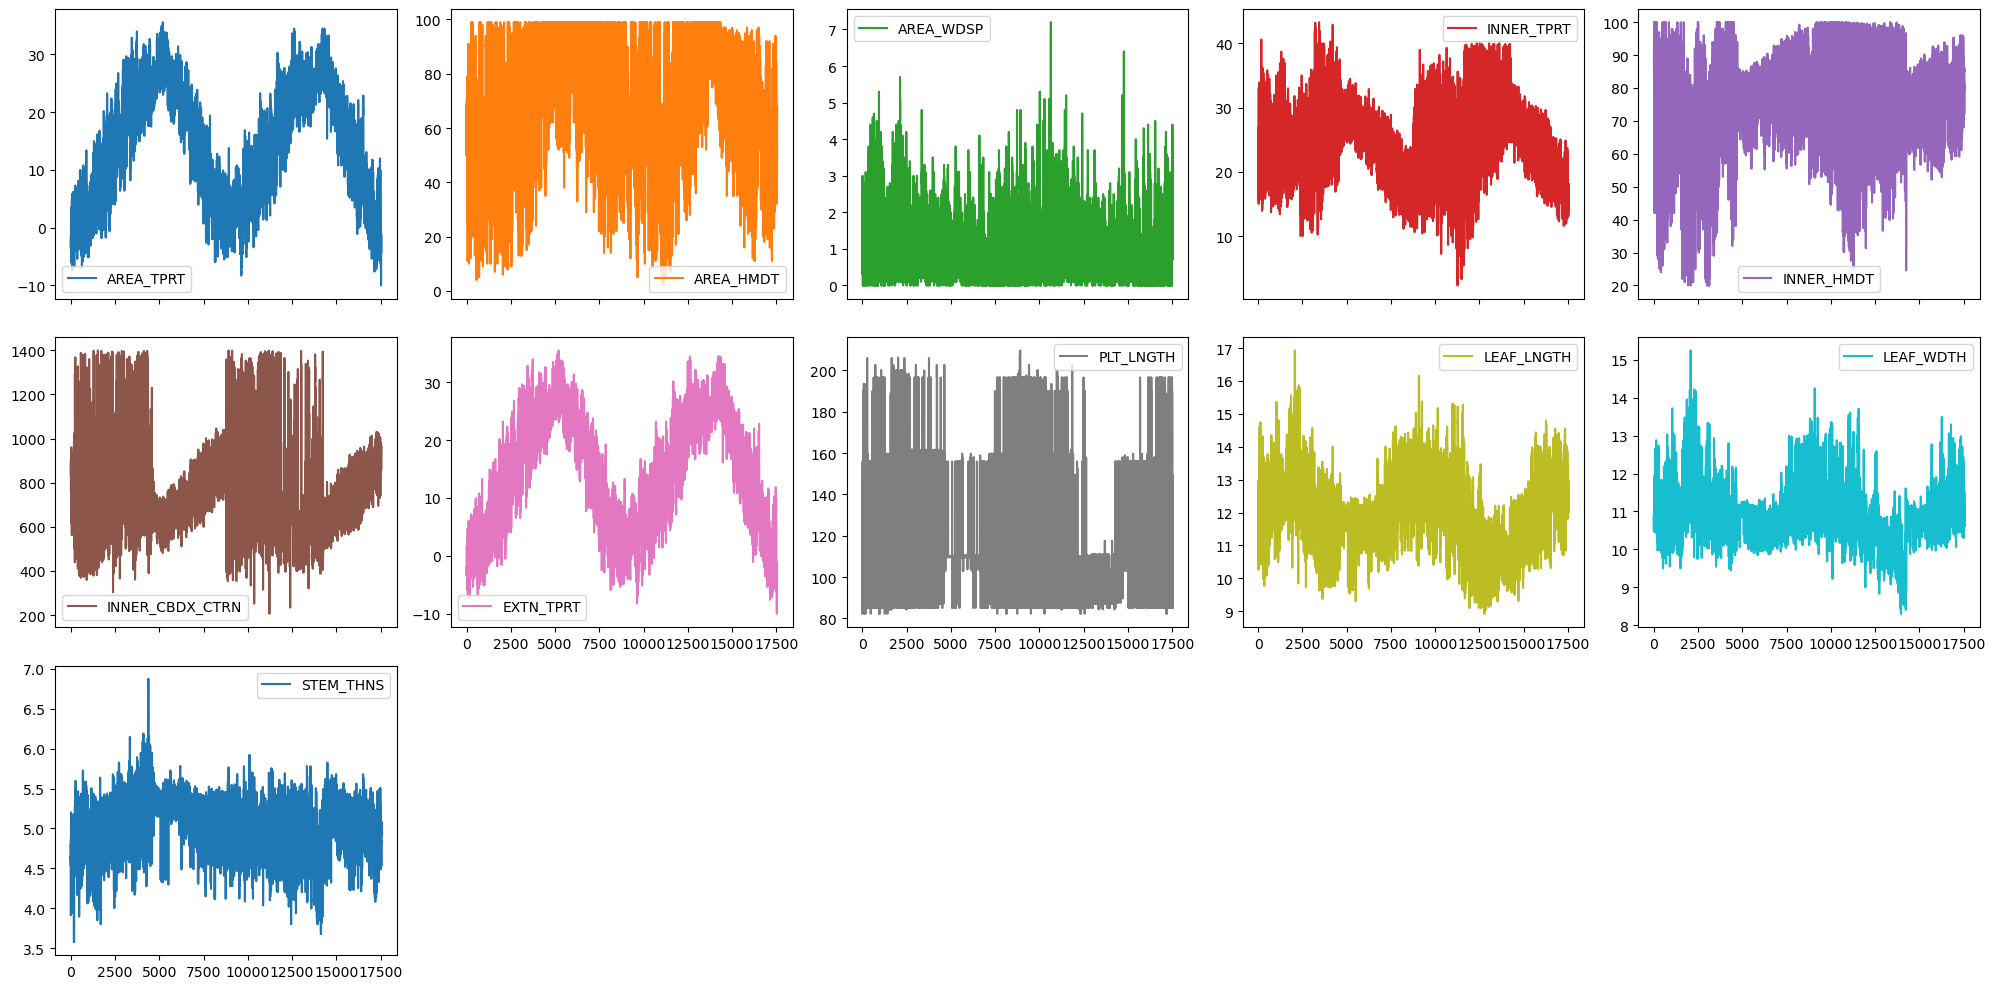

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

df44 = df.drop(['SHPMN_QTY', 'SHPMN_AMT'], axis=1)
df44.plot(subplots=True, layout=(3, 5), figsize=(20, 10))
plt.tight_layout()
plt.show()

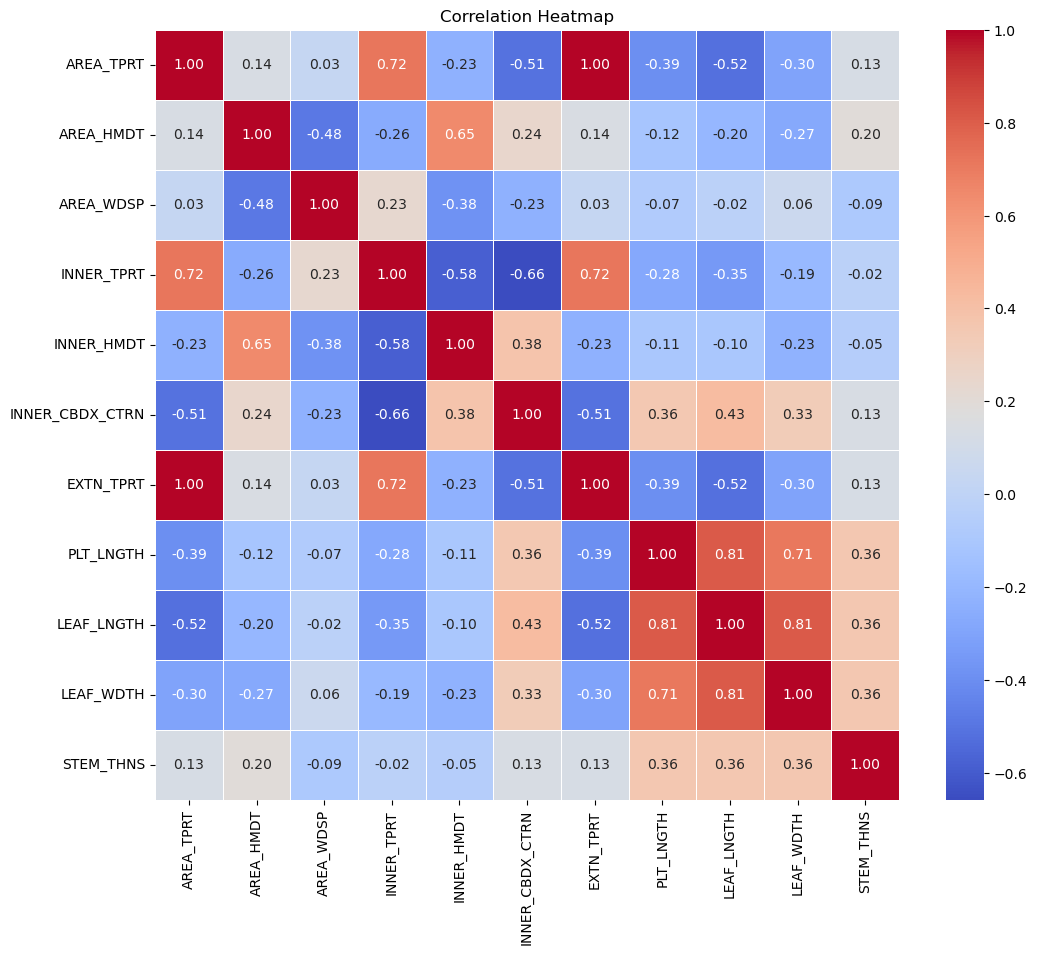

In [51]:
df55 = df44.drop(['MSRM_DT'], axis=1)
corr = df55.corr()

# 히트맵 생성
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Data Scaling

In [52]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Scaling (할지말지 고민중)
ms = MinMaxScaler()
ss = StandardScaler()

X_ms = ms.fit_transform(X)
y_ms = ms.fit_transform(y)

ValueError: Expected 2D array, got 1D array instead:
array=[140.4695  85.025   85.025  ... 149.4065 103.043  103.043 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Model

#### **Transformers**

In [53]:
df.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,840.911874,-2.000705,140.4695,12.472375,10.728500,4.638229,NaN,NaN
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,856.601990,-3.072417,85.0250,12.041000,10.478000,4.598771,NaN,NaN
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,871.298626,-2.544091,85.0250,11.967500,10.811375,4.757417,NaN,NaN
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,878.309889,-2.568719,149.4065,12.698500,10.898375,4.805033,NaN,NaN
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,893.520363,-3.455161,140.4695,12.699500,10.897500,4.579338,NaN,NaN


In [54]:
# 0으로 채워야 되는 행 구간: 0-1416, 5832-10200, 14617-17544

In [55]:
#  지정된 행에 0을 넣기
df.loc[0:1416, ['SHPMN_QTY', 'SHPMN_AMT']] = 0
df.loc[5832:10200, ['SHPMN_QTY', 'SHPMN_AMT']] = 0
df.loc[14617:17544, ['SHPMN_QTY', 'SHPMN_AMT']] = 0

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSRM_DT          17544 non-null  object 
 1   AREA_TPRT        17544 non-null  float64
 2   AREA_HMDT        17544 non-null  float64
 3   AREA_WDSP        17544 non-null  float64
 4   INNER_TPRT       17544 non-null  float64
 5   INNER_HMDT       17544 non-null  float64
 6   INNER_CBDX_CTRN  17544 non-null  float64
 7   EXTN_TPRT        17544 non-null  float64
 8   PLT_LNGTH        17544 non-null  float64
 9   LEAF_LNGTH       17544 non-null  float64
 10  LEAF_WDTH        17544 non-null  float64
 11  STEM_THNS        17544 non-null  float64
 12  SHPMN_QTY        11353 non-null  float64
 13  SHPMN_AMT        11353 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.9+ MB


In [57]:
df.head()

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.1,87.0,840.911874,-2.000705,140.4695,12.472375,10.728500,4.638229,0.0,0.0
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.8,87.0,856.601990,-3.072417,85.0250,12.041000,10.478000,4.598771,0.0,0.0
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.5,87.0,871.298626,-2.544091,85.0250,11.967500,10.811375,4.757417,0.0,0.0
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.1,87.0,878.309889,-2.568719,149.4065,12.698500,10.898375,4.805033,0.0,0.0
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.8,88.0,893.520363,-3.455161,140.4695,12.699500,10.897500,4.579338,0.0,0.0


In [58]:
#아래는 lstm 근데 이제 오류를 곁들인

In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 데이터 준비
target_var = 'SHPMN_QTY'
features = ['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 
            'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 
            'EXTN_TPRT', 'PLT_LNGTH', 'LEAF_LNGTH', 
            'LEAF_WDTH', 'STEM_THNS']

# 결측값이 있는 인덱스 저장
missing_indices = df.index[df[target_var].isnull()]

# 결측값이 있는 행 제거 (예측에 사용할 데이터)
df_no_na = df.dropna(subset=[target_var] + features)

# 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_no_na[features])

# 시퀀스 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :-1])  # 마지막 열 제외 (타겟)
        y.append(data[i + time_step, -1])      # 마지막 열 (타겟)
    return np.array(X), np.array(y)

# 시퀀스 길이 설정
time_step = 24  # 예: 24시간

X, y = create_dataset(scaled_data, time_step)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))  # 종속 변수의 개수만큼 출력

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=10, batch_size=32)

# 결측값에 대한 예측을 위해 future 데이터 생성
future_data = df[features].copy()
future_data[target_var] = df[target_var]  # 기존 SHPMN_QTY 값을 유지

# 결측값에 대해 예측 수행
for idx in missing_indices:
    past_data = df.loc[idx - time_step + 1:idx][features].values  # 이전 데이터 가져오기
    if past_data.shape[0] < time_step:  # 데이터가 부족할 경우 건너뜀
        continue
    past_data_scaled = scaler.transform(past_data)  # 스케일링
    past_data_scaled = past_data_scaled.reshape((1, past_data_scaled.shape[0], past_data_scaled.shape[1]))  # LSTM 입력 형태로 변환

    # 예측
    predicted_value = model.predict(past_data_scaled)
    # 예측값을 원래 스케일로 되돌리기
    predicted_value = scaler.inverse_transform(np.concatenate((past_data[-1, :-1].reshape(1, -1), predicted_value), axis=1))[:, -1]
    
    # 결측값 대체
    df.loc[idx, target_var] = predicted_value

# 결과 확인
print(df[target_var].isnull().sum())  # 결측값 개수 확인
print(df[[target_var]].head(20))  # 결과 일부 확인


Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.0389
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0155
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0156
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0134
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0134
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0129
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0123
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0119
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0118
Epoch 10/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0115


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 11 and 10 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_1, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,11], [10,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 11), dtype=float32)
  • states=('tf.Tensor(shape=(1, 50), dtype=float32)', 'tf.Tensor(shape=(1, 50), dtype=float32)')
  • training=False

In [60]:
#이건 prophet

In [61]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prophet을 사용하여 결측값을 채우는 함수
def fill_missing_with_prophet(target_series, regressors_df):
    # 결측값이 없는 행들만 Prophet 모델에 사용
    non_null_indices = target_series.dropna().index
    target_series_non_null = target_series.loc[non_null_indices]
    regressors_non_null = regressors_df.loc[non_null_indices]

    # Prophet에 맞는 형식으로 변환
    df_prophet = pd.DataFrame({
        'ds': pd.to_datetime(target_series_non_null.index),  # 시간 데이터를 datetime 형식으로 변환
        'y': target_series_non_null.values  # 예측할 목표 값 
    })

    # 각 부가 변수(regressor)를 추가
    for col in regressors_df.columns:
        df_prophet[col] = regressors_non_null[col].values

    # Prophet 모델 초기화 (계절성 추가)
    model_pr = Prophet(daily_seasonality=True, yearly_seasonality=30, weekly_seasonality=20)

    # 부가 변수(regressor) 추가
    for col in regressors_df.columns:
        model_pr.add_regressor(col)

    # 모델 학습
    model_pr.fit(df_prophet)

    # 전체 기간에 대해 예측할 데이터 준비
    future = pd.DataFrame({'ds': pd.to_datetime(target_series.index)})
    for col in regressors_df.columns:
        future[col] = regressors_df[col].values

    # 예측 수행
    forecast = model_pr.predict(future)

    # 예측 결과에서 'yhat' 값 사용
    predicted_values = forecast['yhat'].values

    # 결측값만 Prophet 예측값으로 채우기
    filled_series = target_series.copy()
    filled_series[target_series.isnull()] = predicted_values[target_series.isnull()]

    return filled_series, predicted_values, model_pr  # 모델도 반환


# 성능 평가 함수 (MSE, RMSE, MAE 계산)
def evaluate_performance(original_series, predicted_values):
    # 결측값이 아닌 부분에 대해 평가
    mask = original_series.notnull()
    
    mse = mean_squared_error(original_series[mask], predicted_values[mask])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original_series[mask], predicted_values[mask])
    
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

# 반응 변수 (예측할 변수)와 예측 변수 설정
target_vars = ['SHPMN_QTY']  # 반응 변수
regressors = ['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'EXTN_TPRT', 'PLT_LNGTH', 'LEAF_LNGTH', 'LEAF_WDTH','STEM_THNS']  # 예측 변수

# 각 반응 변수에 대해 결측값 채우기 및 성능 평가
for target_var in target_vars:
    print(f'Filling missing values for {target_var}...')
    filled_series, predicted_values, model_pr = fill_missing_with_prophet(df[target_var], df[regressors])

    # 성능 평가
    print(f'Evaluating performance for {target_var}...')
    evaluate_performance(df[target_var], predicted_values)
    
    # 채운 시리즈를 원본 DataFrame에 저장
    df[target_var] = filled_series

# 결과 확인
print(df.head())


Filling missing values for SHPMN_QTY...


10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:45:11 - cmdstanpy - INFO - Chain [1] done processing


Evaluating performance for SHPMN_QTY...
MSE: 32340.42014998381
RMSE: 179.83442426294195
MAE: 82.56810086090975
               MSRM_DT  AREA_TPRT  AREA_HMDT  AREA_WDSP  INNER_TPRT  \
0  2019-01-01 00:00:00       -1.9       50.0        1.6        19.1   
1  2019-01-01 01:00:00       -3.2       54.0        1.7        18.8   
2  2019-01-01 02:00:00       -2.5       62.0        2.1        18.5   
3  2019-01-01 03:00:00       -2.5       62.0        1.6        18.1   
4  2019-01-01 04:00:00       -3.6       67.0        0.8        17.8   

   INNER_HMDT  INNER_CBDX_CTRN  EXTN_TPRT  PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  \
0        87.0       840.911874  -2.000705   140.4695   12.472375  10.728500   
1        87.0       856.601990  -3.072417    85.0250   12.041000  10.478000   
2        87.0       871.298626  -2.544091    85.0250   11.967500  10.811375   
3        87.0       878.309889  -2.568719   149.4065   12.698500  10.898375   
4        88.0       893.520363  -3.455161   140.4695   12.699500  1

In [62]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prophet을 사용하여 결측값을 채우는 함수
def fill_missing_with_prophet(target_series, regressors_df):
    # 결측값이 없는 행들만 Prophet 모델에 사용
    non_null_indices = target_series.dropna().index
    target_series_non_null = target_series.loc[non_null_indices]
    regressors_non_null = regressors_df.loc[non_null_indices]

    # Prophet에 맞는 형식으로 변환
    df_prophet = pd.DataFrame({
        'ds': pd.to_datetime(target_series_non_null.index),  # 시간 데이터를 datetime 형식으로 변환
        'y': target_series_non_null.values  # 예측할 목표 값 
    })

    # 각 부가 변수(regressor)를 추가
    for col in regressors_df.columns:
        df_prophet[col] = regressors_non_null[col].values

    # Prophet 모델 초기화 (계절성 추가)
    model_pr = Prophet(daily_seasonality=True, yearly_seasonality=30, weekly_seasonality=20)

    # 부가 변수(regressor) 추가
    for col in regressors_df.columns:
        model_pr.add_regressor(col)

    # 모델 학습
    model_pr.fit(df_prophet)

    # 전체 기간에 대해 예측할 데이터 준비
    future = pd.DataFrame({'ds': pd.to_datetime(target_series.index)})
    for col in regressors_df.columns:
        future[col] = regressors_df[col].values

    # 예측 수행
    forecast = model_pr.predict(future)

    # 예측 결과에서 'yhat' 값 사용
    predicted_values = forecast['yhat'].values

    # 결측값만 Prophet 예측값으로 채우기
    filled_series = target_series.copy()
    filled_series[target_series.isnull()] = predicted_values[target_series.isnull()]

    return filled_series, predicted_values, model_pr  # 모델도 반환


# 성능 평가 함수 (MSE, RMSE, MAE 계산)
def evaluate_performance(original_series, predicted_values):
    # 결측값이 아닌 부분에 대해 평가
    mask = original_series.notnull()
    
    mse = mean_squared_error(original_series[mask], predicted_values[mask])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(original_series[mask], predicted_values[mask])
    
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

# 반응 변수 (예측할 변수)와 예측 변수 설정
target_vars = ['SHPMN_AMT']  # 반응 변수
regressors = ['AREA_TPRT', 'AREA_HMDT', 'AREA_WDSP', 'INNER_TPRT', 'INNER_HMDT', 'INNER_CBDX_CTRN', 'EXTN_TPRT', 'PLT_LNGTH', 'LEAF_LNGTH', 'LEAF_WDTH','STEM_THNS']  # 예측 변수

# 각 반응 변수에 대해 결측값 채우기 및 성능 평가
for target_var in target_vars:
    print(f'Filling missing values for {target_var}...')
    filled_series, predicted_values, model_pr = fill_missing_with_prophet(df[target_var], df[regressors])

    # 성능 평가
    print(f'Evaluating performance for {target_var}...')
    evaluate_performance(df[target_var], predicted_values)
    
    # 채운 시리즈를 원본 DataFrame에 저장
    df[target_var] = filled_series

# 결과 확인
print(df.head())


Filling missing values for SHPMN_AMT...


10:45:23 - cmdstanpy - INFO - Chain [1] start processing
10:47:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluating performance for SHPMN_AMT...
MSE: 456090893007.0533
RMSE: 675345.0177554087
MAE: 319920.63116183743
               MSRM_DT  AREA_TPRT  AREA_HMDT  AREA_WDSP  INNER_TPRT  \
0  2019-01-01 00:00:00       -1.9       50.0        1.6        19.1   
1  2019-01-01 01:00:00       -3.2       54.0        1.7        18.8   
2  2019-01-01 02:00:00       -2.5       62.0        2.1        18.5   
3  2019-01-01 03:00:00       -2.5       62.0        1.6        18.1   
4  2019-01-01 04:00:00       -3.6       67.0        0.8        17.8   

   INNER_HMDT  INNER_CBDX_CTRN  EXTN_TPRT  PLT_LNGTH  LEAF_LNGTH  LEAF_WDTH  \
0        87.0       840.911874  -2.000705   140.4695   12.472375  10.728500   
1        87.0       856.601990  -3.072417    85.0250   12.041000  10.478000   
2        87.0       871.298626  -2.544091    85.0250   11.967500  10.811375   
3        87.0       878.309889  -2.568719   149.4065   12.698500  10.898375   
4        88.0       893.520363  -3.455161   140.4695   12.699500  1

In [63]:
df

,MSRM_DT,AREA_TPRT,AREA_HMDT,AREA_WDSP,INNER_TPRT,INNER_HMDT,INNER_CBDX_CTRN,EXTN_TPRT,PLT_LNGTH,LEAF_LNGTH,LEAF_WDTH,STEM_THNS,SHPMN_QTY,SHPMN_AMT
0,2019-01-01 00:00:00,-1.9,50.0,1.6,19.100000,87.000000,840.911874,-2.000705,140.4695,12.472375,10.728500,4.638229,0.0,0.0
1,2019-01-01 01:00:00,-3.2,54.0,1.7,18.800000,87.000000,856.601990,-3.072417,85.0250,12.041000,10.478000,4.598771,0.0,0.0
2,2019-01-01 02:00:00,-2.5,62.0,2.1,18.500000,87.000000,871.298626,-2.544091,85.0250,11.967500,10.811375,4.757417,0.0,0.0
3,2019-01-01 03:00:00,-2.5,62.0,1.6,18.100000,87.000000,878.309889,-2.568719,149.4065,12.698500,10.898375,4.805033,0.0,0.0
4,2019-01-01 04:00:00,-3.6,67.0,0.8,17.800000,88.000000,893.520363,-3.455161,140.4695,12.699500,10.897500,4.579338,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2020-12-31 19:00:00,-2.4,55.0,1.2,16.163760,79.703424,910.789500,-2.420234,149.4065,12.520875,11.463125,4.898225,0.0,0.0
17540,2020-12-31 20:00:00,-3.2,61.0,0.7,15.238261,82.629882,934.961426,-3.179676,103.0430,12.284625,10.697750,5.088713,0.0,0.0
17541,2020-12-31 21:00:00,-3.7,67.0,0.8,14.456612,85.403780,955.767013,-3.684228,149.4065,12.425875,10.908875,4.873692,0.0,0.0
17542,2020-12-31 22:00:00,-4.0,68.0,1.5,14.222446,85.976279,961.665856,-3.990977,103.0430,12.194500,10.602625,4.902242,0.0,0.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSRM_DT          17544 non-null  object 
 1   AREA_TPRT        17544 non-null  float64
 2   AREA_HMDT        17544 non-null  float64
 3   AREA_WDSP        17544 non-null  float64
 4   INNER_TPRT       17544 non-null  float64
 5   INNER_HMDT       17544 non-null  float64
 6   INNER_CBDX_CTRN  17544 non-null  float64
 7   EXTN_TPRT        17544 non-null  float64
 8   PLT_LNGTH        17544 non-null  float64
 9   LEAF_LNGTH       17544 non-null  float64
 10  LEAF_WDTH        17544 non-null  float64
 11  STEM_THNS        17544 non-null  float64
 12  SHPMN_QTY        17544 non-null  float64
 13  SHPMN_AMT        17544 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.9+ MB


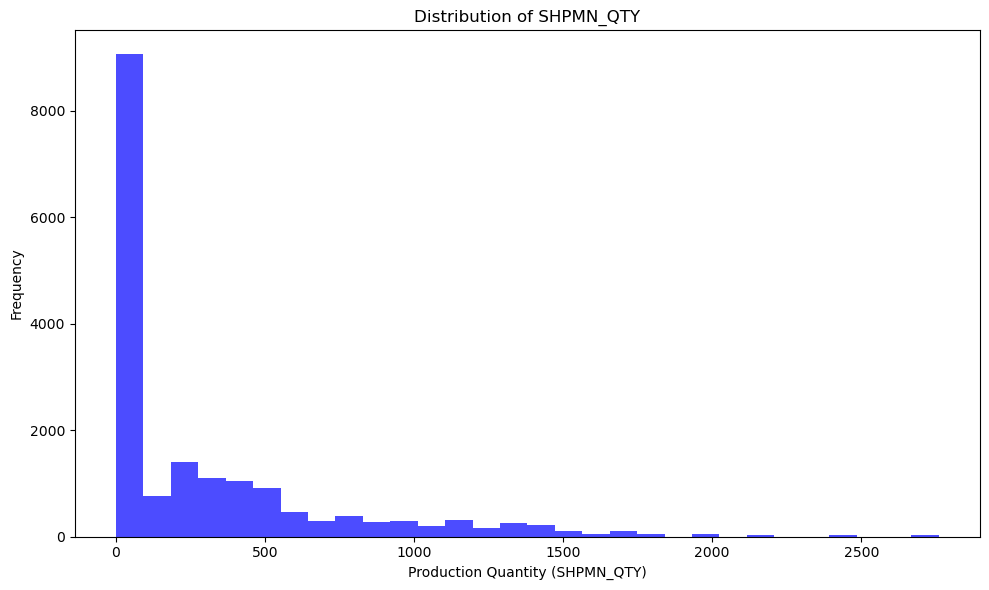

In [65]:
import matplotlib.pyplot as plt

# 결측값을 제외한 SHPMN_QTY의 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(df['SHPMN_QTY'].dropna(), bins=30, color='blue', alpha=0.7)

# 그래프 설정
plt.title('Distribution of SHPMN_QTY')
plt.xlabel('Production Quantity (SHPMN_QTY)')
plt.ylabel('Frequency')
plt.tight_layout()

# 히스토그램 출력
plt.show()



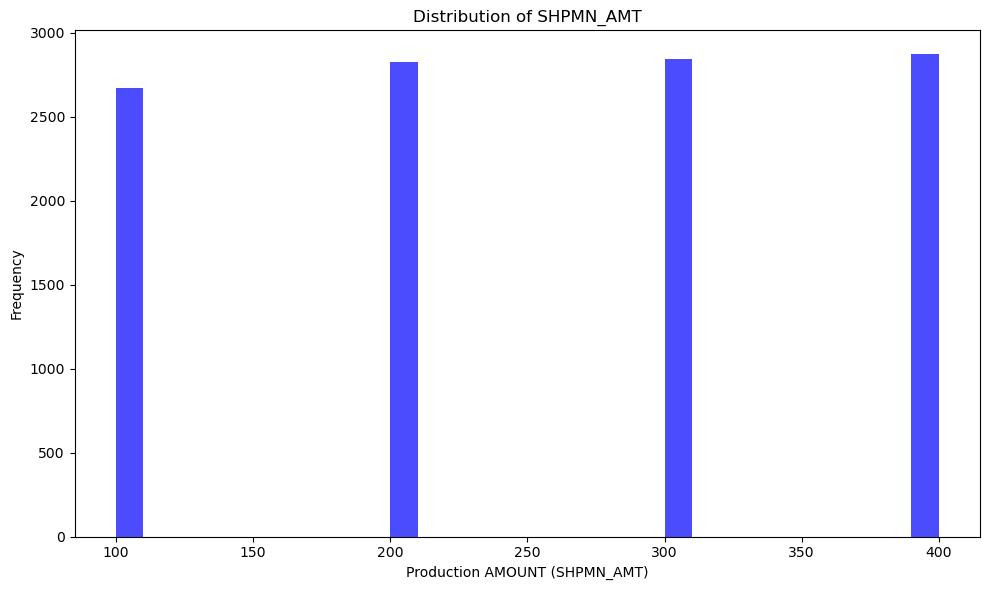

In [68]:
import matplotlib.pyplot as plt

# 결측값을 제외한 SHPMN_QTY의 히스토그램 그리기
plt.figure(figsize=(10, 6))
plt.hist(df['SHPMN_AMT'].dropna(), bins=30, color='blue', alpha=0.7)

# 그래프 설정
plt.title('Distribution of SHPMN_AMT')
plt.xlabel('Production AMOUNT (SHPMN_AMT)')
plt.ylabel('Frequency')
plt.tight_layout()

# 히스토그램 출력
plt.show()

In [66]:
#이건 tft 랑 lstm 합친 거. 돌아가긴 하는데 뭔가 이상함

In [67]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 준비 (예시 데이터 생성)
data = {
    'feature_0': np.random.rand(17544),
    'feature_1': np.random.rand(17544),
    # ...
    'feature_12': np.random.rand(17544),
    'SHPMN_QTY': np.random.choice([np.nan, 1, 2, 3, 4], size=17544),
    'SHPMN_AMT': np.random.choice([np.nan, 100, 200, 300, 400], size=17544)
}
df = pd.DataFrame(data)

# 결측값 제거 및 데이터 분할
df = df.dropna(subset=['SHPMN_QTY', 'SHPMN_AMT'])  # 결측값이 있는 행 제거
X = df.drop(columns=['SHPMN_QTY', 'SHPMN_AMT']).values
y = df[['SHPMN_QTY', 'SHPMN_AMT']].values

# 훈련 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TFT 모델 정의
class TemporalFusionTransformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super(TemporalFusionTransformer, self).__init__()
        self.lstm = layers.LSTM(64, return_sequences=False)  # 마지막 시간 단계의 출력을 받음
        self.dense1 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense1(x)
        return self.output_layer(x)

# 입력 데이터의 차원 조정
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (샘플 수, 타임스텝, 특징 수)
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 모델 생성
model = TemporalFusionTransformer(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
model.compile(optimizer='adam', loss='mse')

# 모델 학습
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# 예측
predictions = model.predict(X_test_reshaped)

# 결과 확인
print(predictions)


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 36895.8945 - val_loss: 20126.0000
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13260.6182 - val_loss: 6970.5000
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6915.4634 - val_loss: 6858.5859
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6916.8335 - val_loss: 6739.6089
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6841.2729 - val_loss: 6641.4756
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6734.0513 - val_loss: 6559.5586
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6449.3403 - val_loss: 6491.9209
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6577.5908 - val_loss: 6441.1348
Epoch 9/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6476.0688 - val_loss: 6366.0015
Epoch 10/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6291.9185 - val_loss: 6332.2163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[[  2.3321853 256.3963   ]
 [  2.2493